In [1]:
# installing 1.0.3 because this version of pandas supports write to s3
!pip install pandas==1.0.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
teamname = '9417-brhuang-unsw'
data_folder='s3://tf-trachack-data/212/'
root_folder='s3://tf-trachack-notebooks/'+'9417-brhuang-unsw'+'/jupyter/jovyan/'

In [5]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns

In [6]:
def create_var_sum(df, save=None):
    """
    Input: 
      df = data frame to summarise
      save = string name of dataframe you wish to save
    Returns:
      A dataframe that breaks down all variables in a dataframe by unique, missing, datatype, and frequency,
      Option to save the file
    """
    result = pd.DataFrame({
        'Col':          df.columns,
        'Unique':       [df[col].nunique() for col in df.columns],
        'Missing':      [round(1 - df[col].count()/len(df[col]), 2) for col in df.columns],
        'Datatype':     list(df.dtypes),
        'Most Freq':    [list(df[col].value_counts().index[:5]) for col in df.columns],
        'Least Freq':   [list(df[col].value_counts().index[-5:]) for col in df.columns]})
    
    if save != None:
        result.to_excel(f"{WRKDIR}/Data/new/'VariableSummary{save}.xls", index = False)

    return result

In [7]:
def drop_infrequent_categories(df: pd.DataFrame, cols: list, thresh: int = 10000, replace_with: str = "other"):
        for col in cols:
            value_counts = df[col].value_counts()
            to_remove = value_counts[value_counts <= thresh].index
            df[col].replace(to_remove, replace_with, inplace=True)

## TODO:
### Join, clean and preprocess the following tables

<b>upgrades.csv</b> - base dataset that has line_id, upgrade_date and upgrade columns.

<b>customer_info.csv</b> - customer info has carrier, plan and activation information for each line_id. One line_id in upgrades data has one and only record in customer info, hence you can do inner join on both. 

<b>redemptions.csv</b> - redemptions has all the plan redemption details for each line_id. One line_id in upgrades data has more than one record in redemptions, hence inner join would be the right choice for both.

<b>deactivations.csv</b> - deactivations has the deactivation details for each line_id. One line_id in upgrades data has more than one record in deactivations, hence inner join would be the right choice for both.

<b>reactivations.csv</b> - reactivations has the reactivation details for each line_id. One line_id in upgrades data has more than one record in reactivations, hence inner join would be the right choice for both.

<b>suspensions.csv</b> - suspension is when a customer is more than 15 days past due. One line_id in upgrades data may not have a record in suspensions, hence left join would be the right choice for both.

### Setting Up

In [8]:
# importing tables
upgrades_df = pd.read_csv(data_folder+"data/dev/upgrades.csv")
customer_info_df = pd.read_csv(data_folder+"data/dev/customer_info.csv", na_values = '[NULL]')
redemptions_df = pd.read_csv(data_folder+"data/dev/redemptions.csv")
deactivations_df = pd.read_csv(data_folder+"data/dev/deactivations.csv")
reactivations_df = pd.read_csv(data_folder+"data/dev/reactivations.csv")
suspensions_df = pd.read_csv(data_folder+"data/dev/suspensions.csv")

In [9]:
print(f"upgrades_df has shape {upgrades_df.shape}")
print(f"customer_info_df has shape {customer_info_df.shape}")
print(f"redemptions_df has shape {redemptions_df.shape}")
print(f"deactivations_df has shape {deactivations_df.shape}")
print(f"reactivations_df has shape {reactivations_df.shape}")
print(f"suspensions_df has shape {suspensions_df.shape}")

upgrades_df has shape (55868, 3)
customer_info_df has shape (55868, 6)
redemptions_df has shape (641493, 6)
deactivations_df has shape (256754, 3)
reactivations_df has shape (248597, 3)
suspensions_df has shape (535849, 3)


In [10]:
# to ensure there is no lost data lets compare the unique line_ids accross tables
upgrades_set = set(upgrades_df.line_id)
redemptions_set = set(redemptions_df.line_id)
deactivations_set = set(deactivations_df.line_id)
reactivations_set = set(reactivations_df.line_id)
suspensions_set = set(suspensions_df.line_id)

print(f"The total number of unique line_id's is {len(list(upgrades_set))}")
print()
print(f"The number of unique line_id's in redemptions are: {len(list(redemptions_set))}")
print(f"The number of line_ids that didn't redeem is:      {len(upgrades_set.difference(redemptions_set))}")
print()
print(f"The number of unique line_id's in deactivations are: {len(list(deactivations_set))}")
print(f"The number of line_ids that didn't deactivate is:    {len(upgrades_set.difference(deactivations_set))}")
print()
print(f"The number of unique line_id's in reactivations are: {len(list(reactivations_set))}")
print(f"The number of line_ids that didn't reactivate is:    {len(upgrades_set.difference(reactivations_set))}")
print()
print(f"The number of unique line_id's in suspensions are: {len(list(suspensions_set))}")
print(f"The number of line_ids that weren't suspended is:  {len(upgrades_set.difference(suspensions_set))}")

The total number of unique line_id's is 55868

The number of unique line_id's in redemptions are: 54885
The number of line_ids that didn't redeem is:      983

The number of unique line_id's in deactivations are: 44757
The number of line_ids that didn't deactivate is:    11111

The number of unique line_id's in reactivations are: 40992
The number of line_ids that didn't reactivate is:    14876

The number of unique line_id's in suspensions are: 48539
The number of line_ids that weren't suspended is:  7329


### Cleaning upgrades

In [11]:
upgrades_df.upgrade.replace(('yes', 'no'), (1, 0), inplace=True)
upgrades_df

,line_id,date_observed,upgrade
0,f0b99d3b-32f7-4464-8fa8-87f27c9810a8,2021-03-14,1
1,a2ec0baf-1720-4b1b-bfa3-db00ac8fcb00,2021-03-10,1
2,dd3a01a3-7baf-4605-9799-ce434328a20d,2021-03-10,0
3,5cf5917c-f407-4cc7-9d6d-dafe8ec0eccc,2021-03-13,0
4,6437fcbd-02c4-4c52-b5b2-f7e535ecec47,2021-03-10,1
...,...,...,...
55863,f89b108a-f453-4419-a4dc-5bf8e1cd1f1a,2021-03-11,0
55864,b703f1d4-57ba-48b6-8adf-46d7aba6a406,2021-03-13,0
55865,e3b2212c-906e-4a8f-8307-6b88fc64d7a0,2021-03-11,0
55866,828df9bf-279c-47c3-96c2-92177a50b8fd,2021-03-14,0


<AxesSubplot:>

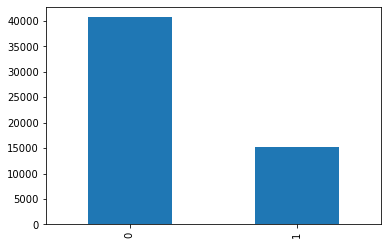

In [12]:
upgrades_df['upgrade'].value_counts().plot(kind = 'bar') #1 is yes, 0 is no

In [13]:
upgrades_df['upgrade'].value_counts()

0    40694
1    15174
Name: upgrade, dtype: int64

In [14]:
upgrades_df.isnull().sum()

line_id          0
date_observed    0
upgrade          0
dtype: int64

### Cleaning Customer Info

In [15]:
customer_info_df = pd.read_csv(data_folder+"data/dev/customer_info.csv", na_values = '[NULL]')

In [16]:
customer_info_df.plan_name.unique()

array([nan, 'plan 2', 'plan 1', 'Other', 'plan 3', 'plan 4'], dtype=object)

<AxesSubplot:>

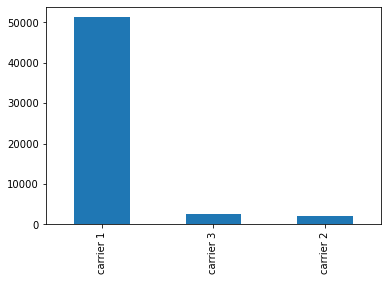

In [17]:
customer_info_df['carrier'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

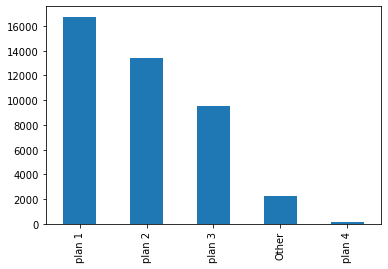

In [18]:
customer_info_df['plan_name'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

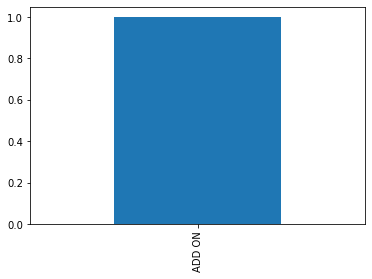

In [19]:
customer_info_df['plan_subtype'].value_counts().plot(kind = 'bar')

In [20]:
#dropped this, as plan_subtype is nearly useless (everything but 1 row is NaN or Null)
customer_info_df = customer_info_df.drop(['plan_subtype'], axis = 1)
customer_info_df

,line_id,carrier,first_activation_date,plan_name,redemption_date
0,e1b8b731-f3c6-4a8a-b09c-f3556888c868,carrier 1,2017-12-12,NaN,NaN
1,51c1e947-f8a4-4a9c-94f8-45f52198f329,carrier 1,2021-01-18,plan 2,2021-02-25
2,ba024df0-cfa9-4c88-ac48-87e0c055f650,carrier 1,2018-01-16,NaN,NaN
3,21be69d6-5ebf-4449-bc0a-828ac5ea5d8a,carrier 1,2021-01-18,plan 1,2021-01-18
4,1f385125-deed-424b-9a29-13b1c6dc3dda,carrier 1,2020-10-31,plan 1,2021-02-02
...,...,...,...,...,...
55863,8052a7e7-2c09-4873-a583-f9dd7f02e27b,carrier 1,2017-10-30,plan 1,2021-02-21
55864,8eacf359-f96a-4749-92f1-ef500d0e064e,carrier 1,2021-01-26,NaN,NaN
55865,76531942-f047-4f2c-b2d2-c986312bd723,carrier 1,NaN,NaN,NaN
55866,62ca5877-391e-47aa-8956-80dda4af35e9,carrier 1,2020-10-02,plan 2,2021-02-25


In [21]:
customer_info_df.isnull().sum()

line_id                      0
carrier                      0
first_activation_date      721
plan_name                13856
redemption_date          13856
dtype: int64

In [22]:
customer_info_df['plan_name'].isnull().sum()

13856

In [23]:
customer_info_df['plan_name'] = customer_info_df['plan_name'].fillna("not_given")

In [24]:
customer_info_df['plan_name'].isnull().sum()

0

In [25]:
#one hot encode
ci_cat_features_df = customer_info_df.loc[:,['line_id','carrier', 'plan_name']]
ci_cat_features_df = pd.get_dummies(ci_cat_features_df, columns=['carrier', 'plan_name'])
#ci_cat_features_df = ci_cat_features_df.groupby('line_id')
ci_cat_features_df

,line_id,carrier_carrier 1,carrier_carrier 2,carrier_carrier 3,plan_name_Other,plan_name_not_given,plan_name_plan 1,plan_name_plan 2,plan_name_plan 3,plan_name_plan 4
0,e1b8b731-f3c6-4a8a-b09c-f3556888c868,1,0,0,0,1,0,0,0,0
1,51c1e947-f8a4-4a9c-94f8-45f52198f329,1,0,0,0,0,0,1,0,0
2,ba024df0-cfa9-4c88-ac48-87e0c055f650,1,0,0,0,1,0,0,0,0
3,21be69d6-5ebf-4449-bc0a-828ac5ea5d8a,1,0,0,0,0,1,0,0,0
4,1f385125-deed-424b-9a29-13b1c6dc3dda,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
55863,8052a7e7-2c09-4873-a583-f9dd7f02e27b,1,0,0,0,0,1,0,0,0
55864,8eacf359-f96a-4749-92f1-ef500d0e064e,1,0,0,0,1,0,0,0,0
55865,76531942-f047-4f2c-b2d2-c986312bd723,1,0,0,0,1,0,0,0,0
55866,62ca5877-391e-47aa-8956-80dda4af35e9,1,0,0,0,0,0,1,0,0


In [26]:
customer_info_df.rename(columns={'redemption_date':'last_redemption_date'},inplace=True)
customer_info_df

,line_id,carrier,first_activation_date,plan_name,last_redemption_date
0,e1b8b731-f3c6-4a8a-b09c-f3556888c868,carrier 1,2017-12-12,not_given,NaN
1,51c1e947-f8a4-4a9c-94f8-45f52198f329,carrier 1,2021-01-18,plan 2,2021-02-25
2,ba024df0-cfa9-4c88-ac48-87e0c055f650,carrier 1,2018-01-16,not_given,NaN
3,21be69d6-5ebf-4449-bc0a-828ac5ea5d8a,carrier 1,2021-01-18,plan 1,2021-01-18
4,1f385125-deed-424b-9a29-13b1c6dc3dda,carrier 1,2020-10-31,plan 1,2021-02-02
...,...,...,...,...,...
55863,8052a7e7-2c09-4873-a583-f9dd7f02e27b,carrier 1,2017-10-30,plan 1,2021-02-21
55864,8eacf359-f96a-4749-92f1-ef500d0e064e,carrier 1,2021-01-26,not_given,NaN
55865,76531942-f047-4f2c-b2d2-c986312bd723,carrier 1,NaN,not_given,NaN
55866,62ca5877-391e-47aa-8956-80dda4af35e9,carrier 1,2020-10-02,plan 2,2021-02-25


In [27]:
customer_info_df.carrier.unique()

array(['carrier 1', 'carrier 2', 'carrier 3'], dtype=object)

In [28]:
customer_info_df

,line_id,carrier,first_activation_date,plan_name,last_redemption_date
0,e1b8b731-f3c6-4a8a-b09c-f3556888c868,carrier 1,2017-12-12,not_given,NaN
1,51c1e947-f8a4-4a9c-94f8-45f52198f329,carrier 1,2021-01-18,plan 2,2021-02-25
2,ba024df0-cfa9-4c88-ac48-87e0c055f650,carrier 1,2018-01-16,not_given,NaN
3,21be69d6-5ebf-4449-bc0a-828ac5ea5d8a,carrier 1,2021-01-18,plan 1,2021-01-18
4,1f385125-deed-424b-9a29-13b1c6dc3dda,carrier 1,2020-10-31,plan 1,2021-02-02
...,...,...,...,...,...
55863,8052a7e7-2c09-4873-a583-f9dd7f02e27b,carrier 1,2017-10-30,plan 1,2021-02-21
55864,8eacf359-f96a-4749-92f1-ef500d0e064e,carrier 1,2021-01-26,not_given,NaN
55865,76531942-f047-4f2c-b2d2-c986312bd723,carrier 1,NaN,not_given,NaN
55866,62ca5877-391e-47aa-8956-80dda4af35e9,carrier 1,2020-10-02,plan 2,2021-02-25


In [29]:
clean_customer_info_df = pd.merge(customer_info_df, ci_cat_features_df, on='line_id', how='inner')
clean_customer_info_df = clean_customer_info_df.drop(['plan_name', 'carrier'], axis = 1)
clean_customer_info_df

,line_id,first_activation_date,last_redemption_date,carrier_carrier 1,carrier_carrier 2,carrier_carrier 3,plan_name_Other,plan_name_not_given,plan_name_plan 1,plan_name_plan 2,plan_name_plan 3,plan_name_plan 4
0,e1b8b731-f3c6-4a8a-b09c-f3556888c868,2017-12-12,NaN,1,0,0,0,1,0,0,0,0
1,51c1e947-f8a4-4a9c-94f8-45f52198f329,2021-01-18,2021-02-25,1,0,0,0,0,0,1,0,0
2,ba024df0-cfa9-4c88-ac48-87e0c055f650,2018-01-16,NaN,1,0,0,0,1,0,0,0,0
3,21be69d6-5ebf-4449-bc0a-828ac5ea5d8a,2021-01-18,2021-01-18,1,0,0,0,0,1,0,0,0
4,1f385125-deed-424b-9a29-13b1c6dc3dda,2020-10-31,2021-02-02,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
55863,8052a7e7-2c09-4873-a583-f9dd7f02e27b,2017-10-30,2021-02-21,1,0,0,0,0,1,0,0,0
55864,8eacf359-f96a-4749-92f1-ef500d0e064e,2021-01-26,NaN,1,0,0,0,1,0,0,0,0
55865,76531942-f047-4f2c-b2d2-c986312bd723,NaN,NaN,1,0,0,0,1,0,0,0,0
55866,62ca5877-391e-47aa-8956-80dda4af35e9,2020-10-02,2021-02-25,1,0,0,0,0,0,1,0,0


### Cleaning redemptions

* sum gross_revenue 
* count redemption_dates
* one hot encode channel, then sum
* one hot encode revenue_type, then sum
* one hot encode redemption_type, then sum

In [30]:
redemptions_df.columns

Index(['line_id', 'channel', 'gross_revenue', 'redemption_date',
       'redemption_type', 'revenue_type'],
      dtype='object')

<AxesSubplot:>

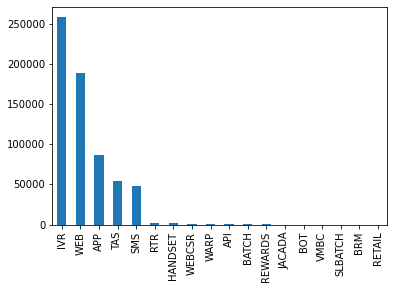

In [31]:
redemptions_df['channel'].value_counts().plot(kind = 'bar') #Similar to reactivations spread

<AxesSubplot:>

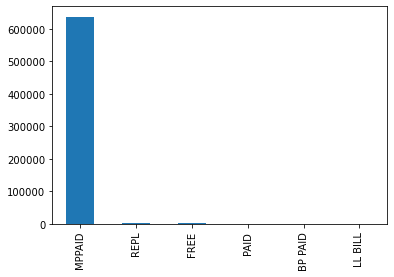

In [32]:
redemptions_df['revenue_type'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

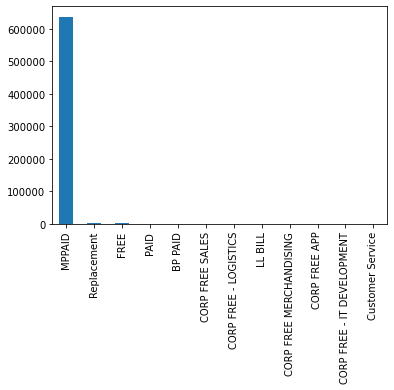

In [33]:
redemptions_df['redemption_type'].value_counts().plot(kind = 'bar')

In [34]:
redemptions_num_features_df = redemptions_df.drop(['channel','redemption_type','revenue_type'], axis=1)

In [35]:
gross_redemption_revenue_per_line_id = redemptions_num_features_df.groupby(['line_id'])['gross_revenue'].sum()
redemption_count_per_line_id = redemptions_num_features_df.groupby(['line_id'])['redemption_date'].count()

In [36]:
redemptions_num_features_df=pd.merge(redemptions_num_features_df,gross_redemption_revenue_per_line_id, on='line_id',how='inner')
redemptions_num_features_df=pd.merge(redemptions_num_features_df,redemption_count_per_line_id, on='line_id',how='inner')

In [37]:
redemptions_num_features_df = redemptions_num_features_df.drop(['redemption_date_x','gross_revenue_x'], axis=1)

In [38]:
rename_dict = {'redemption_date_y':'total_redemptions',
               'gross_revenue_y':'total_revenue',
              }
redemptions_num_features_df.rename(columns = rename_dict, inplace = True)
redemptions_num_features_df.drop_duplicates(inplace=True)

                   total_revenue  total_redemptions
total_revenue           1.000000           0.951726
total_redemptions       0.951726           1.000000


<AxesSubplot:>

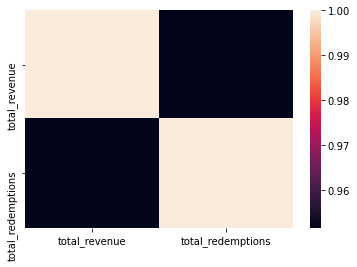

In [39]:
redemptions_df_corr = redemptions_num_features_df.corr()
print(redemptions_df_corr)
sns.heatmap(redemptions_df_corr)

In [40]:
# drop total_revenue, as correlation too high
clean_redemptions_df = redemptions_num_features_df.drop(['total_revenue'], axis = 1)
clean_redemptions_df

,line_id,total_redemptions
0,003a475f-a35c-4d9d-b72d-178dede369e3,27
27,a753a5d8-3260-41bc-aba0-84dde1c7c4c0,30
57,45436c39-7de2-4270-ac15-2ffd4466a5a1,23
80,4ace8faa-6433-4715-8a15-9bd6abf074f2,29
109,04918ddd-77b3-4e43-aa60-4796795e0292,49
...,...,...
641488,d8facaf1-0624-47e9-8901-8bf8deb10914,1
641489,6415b119-9a3d-4ffa-9bb1-379f06838179,1
641490,a1dd40df-332c-4d1b-b0f3-8e9a59166996,1
641491,a6716bd1-af71-4667-babb-3ffde9cf3e20,1


### Cleaning Suspensions

In [41]:
suspensions_df.isnull().sum()

line_id                  0
suspension_start_date    0
suspension_end_date      0
dtype: int64

In [42]:
suspensions_var_sum = create_var_sum(suspensions_df)
suspensions_var_sum

,Col,Unique,Missing,Datatype,Most Freq,Least Freq
0,line_id,48539,0.0,object,"[1e0891c7-fa49-472b-a5c8-31b7e2ef52cc, 68a2d2e...","[68043cef-680f-480f-ade0-a2f37f074122, dd6cc37..."
1,suspension_start_date,5142,0.0,object,"[2021-01-23, 2021-01-24, 2021-02-23, 2021-02-2...","[2008-07-11, 2008-10-30, 2008-01-18, 2008-04-2..."
2,suspension_end_date,5142,0.0,object,"[2021-02-24, 2021-02-25, 2021-02-23, 2021-02-2...","[2006-10-12, 2007-04-26, 2007-05-01, 2009-01-2..."


Aggregated 'suspension_start_date', per 'line_id' to create the 'total_suspensions' feature <br>
Aggregated 'suspension_end_date', per 'line_id' to create the 'total_unsuspensions' feature

In [43]:
suspensions_cat_df = suspensions_df.groupby('line_id')
suspensions_total_df = suspensions_cat_df.count()
rename_dict = {'suspension_start_date':'total_suspensions',
               'suspension_end_date':'total_unsuspensions',
              }
suspensions_total_df.rename(columns=rename_dict, inplace=True)
suspensions_total_df

,total_suspensions,total_unsuspensions
line_id,,
000027f8-7b65-407a-a90e-619e16f7cd60,3,3
0000871b-a418-424b-b6f6-79cfc4db0a12,11,11
00022391-6d4e-41bb-a0ca-2af25cec301d,6,6
00040e10-1cd1-434c-bf4f-3fd3cc6ecdf8,2,2
00044afe-35a4-4313-92ec-36618c83fb23,35,35
...,...,...
fff51de7-e63a-4797-aba5-fd8c9d7df07a,1,1
fff63e2d-ddcb-49cd-8ded-80e3c592cfab,6,6
fffa1fc2-fb6a-4284-a6b0-8199cffe383b,10,10


In [44]:
suspensions_max_df = suspensions_cat_df.max()

In [45]:
suspensions_max_df

,suspension_start_date,suspension_end_date
line_id,,
000027f8-7b65-407a-a90e-619e16f7cd60,2021-02-01,2021-02-02
0000871b-a418-424b-b6f6-79cfc4db0a12,2020-11-02,2020-12-02
00022391-6d4e-41bb-a0ca-2af25cec301d,2021-01-31,2021-03-02
00040e10-1cd1-434c-bf4f-3fd3cc6ecdf8,2021-02-21,2021-02-23
00044afe-35a4-4313-92ec-36618c83fb23,2021-02-20,2021-02-24
...,...,...
fff51de7-e63a-4797-aba5-fd8c9d7df07a,2021-02-22,2021-02-24
fff63e2d-ddcb-49cd-8ded-80e3c592cfab,2017-10-10,2017-10-12
fffa1fc2-fb6a-4284-a6b0-8199cffe383b,2021-01-23,2021-01-24


In [46]:
rename_dict = {'suspension_start_date':'last_suspension_start_date',
               'suspension_end_date':'last_suspensions_end_date',
              }
suspensions_max_df.rename(columns=rename_dict, inplace=True)
suspensions_max_df

,last_suspension_start_date,last_suspensions_end_date
line_id,,
000027f8-7b65-407a-a90e-619e16f7cd60,2021-02-01,2021-02-02
0000871b-a418-424b-b6f6-79cfc4db0a12,2020-11-02,2020-12-02
00022391-6d4e-41bb-a0ca-2af25cec301d,2021-01-31,2021-03-02
00040e10-1cd1-434c-bf4f-3fd3cc6ecdf8,2021-02-21,2021-02-23
00044afe-35a4-4313-92ec-36618c83fb23,2021-02-20,2021-02-24
...,...,...
fff51de7-e63a-4797-aba5-fd8c9d7df07a,2021-02-22,2021-02-24
fff63e2d-ddcb-49cd-8ded-80e3c592cfab,2017-10-10,2017-10-12
fffa1fc2-fb6a-4284-a6b0-8199cffe383b,2021-01-23,2021-01-24


In [47]:
clean_suspensions_df = pd.merge(suspensions_total_df, suspensions_max_df, on='line_id', how='inner')
clean_suspensions_df

,total_suspensions,total_unsuspensions,last_suspension_start_date,last_suspensions_end_date
line_id,,,,
000027f8-7b65-407a-a90e-619e16f7cd60,3,3,2021-02-01,2021-02-02
0000871b-a418-424b-b6f6-79cfc4db0a12,11,11,2020-11-02,2020-12-02
00022391-6d4e-41bb-a0ca-2af25cec301d,6,6,2021-01-31,2021-03-02
00040e10-1cd1-434c-bf4f-3fd3cc6ecdf8,2,2,2021-02-21,2021-02-23
00044afe-35a4-4313-92ec-36618c83fb23,35,35,2021-02-20,2021-02-24
...,...,...,...,...
fff51de7-e63a-4797-aba5-fd8c9d7df07a,1,1,2021-02-22,2021-02-24
fff63e2d-ddcb-49cd-8ded-80e3c592cfab,6,6,2017-10-10,2017-10-12
fffa1fc2-fb6a-4284-a6b0-8199cffe383b,10,10,2021-01-23,2021-01-24


### Cleaning deactivations

In [48]:
deactivations_var_sum = create_var_sum(deactivations_df)
deactivations_var_sum

,Col,Unique,Missing,Datatype,Most Freq,Least Freq
0,line_id,44757,0.0,object,"[5f24bef0-3545-408a-9651-796a4679364d, 6584051...","[14ad3514-f61a-4a3b-b3ce-0809b50133bd, 18db384..."
1,deactivation_date,1446,0.0,object,"[2021-02-24, 2021-02-23, 2021-02-25, 2021-01-2...","[2017-06-27, 2017-08-23, 2017-03-31, 2017-03-3..."
2,deactivation_reason,23,0.0,object,"[PASTDUE, UPGRADE, CUSTOMER REQD, RISK ASSESSM...","[REMOVED_FROM_GROUP, LINE HOTLINED, AVFAILURE,..."


<AxesSubplot:>

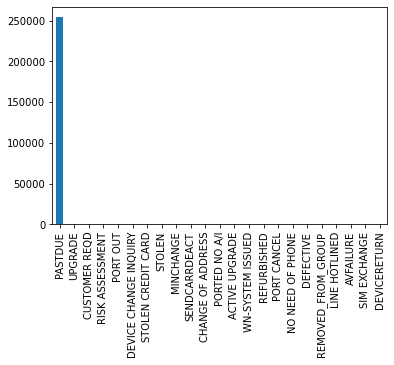

In [49]:
deactivations_df['deactivation_reason'].value_counts().plot(kind = 'bar') 

Since the overwhelming majority of 'deactivation_reason' is 'PASTDUE'the column it self has low variability and is not necessary for model training

In [50]:
deactivations_total_df = deactivations_df[['line_id', 'deactivation_date']].groupby('line_id')

Aggregated 'deactivation_date', per 'line_id' to create the 'total_deactivations' feature

In [51]:
# total deactivations per line_id
deactivations_total_df = deactivations_total_df.count()
deactivations_total_df.rename(columns={'deactivation_date':'total_deactivations'}, inplace=True)
deactivations_total_df

,total_deactivations
line_id,
000027f8-7b65-407a-a90e-619e16f7cd60,3
0000871b-a418-424b-b6f6-79cfc4db0a12,1
00022391-6d4e-41bb-a0ca-2af25cec301d,6
00040e10-1cd1-434c-bf4f-3fd3cc6ecdf8,1
00044afe-35a4-4313-92ec-36618c83fb23,12
...,...
fff51de7-e63a-4797-aba5-fd8c9d7df07a,1
fffa1fc2-fb6a-4284-a6b0-8199cffe383b,7
fffc0209-3cec-4a77-be13-2fff03ede88a,1


In [52]:
#last deactivation
deactivations_max_df = deactivations_df[['line_id', 'deactivation_date']].groupby('line_id')
deactivations_max_df = deactivations_max_df.max()
deactivations_max_df.rename(columns={'deactivation_date':'last_deactivation'}, inplace=True)
deactivations_max_df

,last_deactivation
line_id,
000027f8-7b65-407a-a90e-619e16f7cd60,2021-03-05
0000871b-a418-424b-b6f6-79cfc4db0a12,2020-11-03
00022391-6d4e-41bb-a0ca-2af25cec301d,2021-02-01
00040e10-1cd1-434c-bf4f-3fd3cc6ecdf8,2021-02-22
00044afe-35a4-4313-92ec-36618c83fb23,2021-02-21
...,...
fff51de7-e63a-4797-aba5-fd8c9d7df07a,2021-02-23
fffa1fc2-fb6a-4284-a6b0-8199cffe383b,2021-01-24
fffc0209-3cec-4a77-be13-2fff03ede88a,2021-02-27


In [53]:
clean_deactivations_df = pd.merge(deactivations_total_df, deactivations_max_df, on='line_id',how='inner')
clean_deactivations_df

,total_deactivations,last_deactivation
line_id,,
000027f8-7b65-407a-a90e-619e16f7cd60,3,2021-03-05
0000871b-a418-424b-b6f6-79cfc4db0a12,1,2020-11-03
00022391-6d4e-41bb-a0ca-2af25cec301d,6,2021-02-01
00040e10-1cd1-434c-bf4f-3fd3cc6ecdf8,1,2021-02-22
00044afe-35a4-4313-92ec-36618c83fb23,12,2021-02-21
...,...,...
fff51de7-e63a-4797-aba5-fd8c9d7df07a,1,2021-02-23
fffa1fc2-fb6a-4284-a6b0-8199cffe383b,7,2021-01-24
fffc0209-3cec-4a77-be13-2fff03ede88a,1,2021-02-27


### Reactivations

In [54]:
reactivations_var_sum = create_var_sum(reactivations_df)
reactivations_var_sum

,Col,Unique,Missing,Datatype,Most Freq,Least Freq
0,line_id,40992,0.0,object,"[6584051d-9190-4812-ba2b-f59ba0e5f350, 5f24bef...","[2b6f6881-1626-47e0-a792-0b0b10290729, cf18a58..."
1,reactivation_channel,13,0.0,object,"[IVR, WEB, APP, SMS, TAS]","[JACADA, API, REWARDS, WARP, BOT]"
2,reactivation_date,1446,0.0,object,"[2021-02-24, 2021-02-23, 2021-02-25, 2021-02-2...","[2017-05-21, 2017-03-31, 2017-05-11, 2017-03-3..."


Aggregated 'reactivation_date', per 'line_id' to create the 'total_reactivations' feature

In [55]:
reactivations_total_df = reactivations_df[['line_id', 'reactivation_date']].groupby('line_id')

In [56]:
reactivations_total_df = reactivations_total_df.count()
reactivations_total_df.rename(columns={'reactivation_date':'total_reactivations'}, inplace=True)
reactivations_total_df

,total_reactivations
line_id,
000027f8-7b65-407a-a90e-619e16f7cd60,2
0000871b-a418-424b-b6f6-79cfc4db0a12,1
00022391-6d4e-41bb-a0ca-2af25cec301d,6
00040e10-1cd1-434c-bf4f-3fd3cc6ecdf8,1
00044afe-35a4-4313-92ec-36618c83fb23,12
...,...
fff760bb-4be0-456e-bc10-b6f5b8bdc4dd,1
fffa1fc2-fb6a-4284-a6b0-8199cffe383b,7
fffc0209-3cec-4a77-be13-2fff03ede88a,1


In [57]:
reactivations_max_df = reactivations_df[['line_id', 'reactivation_date']].groupby('line_id')
reactivations_max_df = reactivations_max_df.max()
reactivations_max_df.rename(columns={'reactivation_date':'last_reactivation'}, inplace=True)
reactivations_max_df

,last_reactivation
line_id,
000027f8-7b65-407a-a90e-619e16f7cd60,2021-02-02
0000871b-a418-424b-b6f6-79cfc4db0a12,2021-02-12
00022391-6d4e-41bb-a0ca-2af25cec301d,2021-01-01
00040e10-1cd1-434c-bf4f-3fd3cc6ecdf8,2021-02-23
00044afe-35a4-4313-92ec-36618c83fb23,2021-02-24
...,...
fff760bb-4be0-456e-bc10-b6f5b8bdc4dd,2021-02-15
fffa1fc2-fb6a-4284-a6b0-8199cffe383b,2021-01-24
fffc0209-3cec-4a77-be13-2fff03ede88a,2020-12-28


<AxesSubplot:>

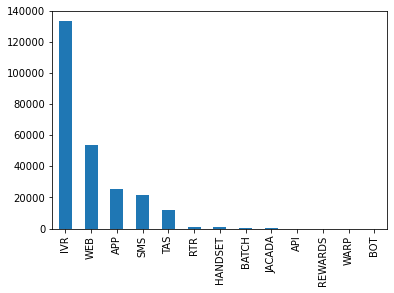

In [58]:
reactivations_df['reactivation_channel'].value_counts().plot(kind = 'bar')

After analysing the makeup of 'reactivation_channel' its clear there is enough variablility for the column to be useful, however, there are a few values are less useful than others since they rarely appear in the data, as such those less frequent values will be dropped and aggregated into an 'other' value.

In [59]:
reactivations_dropping = reactivations_df.copy(deep = True)
drop_infrequent_categories(reactivations_dropping, ['reactivation_channel'], thresh = 2000)
reactivations_dropping['reactivation_channel'].unique()

array(['WEB', 'APP', 'IVR', 'TAS', 'SMS', 'other'], dtype=object)

<AxesSubplot:>

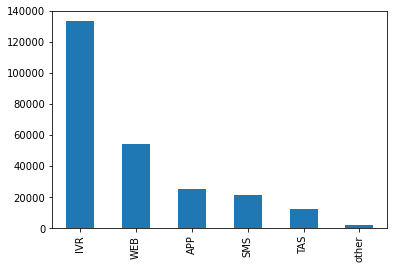

In [60]:
reactivations_dropping['reactivation_channel'].value_counts().plot(kind = 'bar')

In [61]:
reactivations_cat_features_df = reactivations_dropping.loc[:,['line_id','reactivation_channel']]
reactivations_cat_features_df = pd.get_dummies(reactivations_cat_features_df, columns=['reactivation_channel'])
reactivations_cat_features_df = reactivations_cat_features_df.groupby('line_id')
reactivations_cat_features_df = reactivations_cat_features_df.sum()
reactivations_cat_features_df

,reactivation_channel_APP,reactivation_channel_IVR,reactivation_channel_SMS,reactivation_channel_TAS,reactivation_channel_WEB,reactivation_channel_other
line_id,,,,,,
000027f8-7b65-407a-a90e-619e16f7cd60,0,2,0,0,0,0
0000871b-a418-424b-b6f6-79cfc4db0a12,0,1,0,0,0,0
00022391-6d4e-41bb-a0ca-2af25cec301d,0,0,0,1,5,0
00040e10-1cd1-434c-bf4f-3fd3cc6ecdf8,0,0,0,0,1,0
00044afe-35a4-4313-92ec-36618c83fb23,0,12,0,0,0,0
...,...,...,...,...,...,...
fff760bb-4be0-456e-bc10-b6f5b8bdc4dd,0,0,0,1,0,0
fffa1fc2-fb6a-4284-a6b0-8199cffe383b,0,0,2,0,5,0
fffc0209-3cec-4a77-be13-2fff03ede88a,1,0,0,0,0,0


In [62]:
clean_reactivations_df = pd.merge(reactivations_total_df, reactivations_max_df, on='line_id',how='inner')
clean_reactivations_df = pd.merge(clean_reactivations_df, reactivations_cat_features_df,on='line_id',how='inner')
clean_reactivations_df

,total_reactivations,last_reactivation,reactivation_channel_APP,reactivation_channel_IVR,reactivation_channel_SMS,reactivation_channel_TAS,reactivation_channel_WEB,reactivation_channel_other
line_id,,,,,,,,
000027f8-7b65-407a-a90e-619e16f7cd60,2,2021-02-02,0,2,0,0,0,0
0000871b-a418-424b-b6f6-79cfc4db0a12,1,2021-02-12,0,1,0,0,0,0
00022391-6d4e-41bb-a0ca-2af25cec301d,6,2021-01-01,0,0,0,1,5,0
00040e10-1cd1-434c-bf4f-3fd3cc6ecdf8,1,2021-02-23,0,0,0,0,1,0
00044afe-35a4-4313-92ec-36618c83fb23,12,2021-02-24,0,12,0,0,0,0
...,...,...,...,...,...,...,...,...
fff760bb-4be0-456e-bc10-b6f5b8bdc4dd,1,2021-02-15,0,0,0,1,0,0
fffa1fc2-fb6a-4284-a6b0-8199cffe383b,7,2021-01-24,0,0,2,0,5,0
fffc0209-3cec-4a77-be13-2fff03ede88a,1,2020-12-28,1,0,0,0,0,0


### Joining

In [63]:
merged = pd.merge(upgrades_df,clean_customer_info_df,on='line_id',how='inner')
merged = pd.merge(merged, clean_redemptions_df,on='line_id',how='left')
merged = pd.merge(merged, clean_suspensions_df,on='line_id',how='left')
merged = pd.merge(merged, clean_deactivations_df,on='line_id',how='left')
merged = pd.merge(merged, clean_reactivations_df,on='line_id',how='left')

In [64]:
merged

,line_id,date_observed,upgrade,first_activation_date,last_redemption_date,carrier_carrier 1,carrier_carrier 2,carrier_carrier 3,plan_name_Other,plan_name_not_given,...,total_deactivations,last_deactivation,total_reactivations,last_reactivation,reactivation_channel_APP,reactivation_channel_IVR,reactivation_channel_SMS,reactivation_channel_TAS,reactivation_channel_WEB,reactivation_channel_other
0,f0b99d3b-32f7-4464-8fa8-87f27c9810a8,2021-03-14,1,2018-08-06,NaN,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,a2ec0baf-1720-4b1b-bfa3-db00ac8fcb00,2021-03-10,1,2019-04-11,NaN,1,0,0,0,1,...,3.0,2021-02-26,3.0,2021-02-26,0.0,0.0,0.0,0.0,3.0,0.0
2,dd3a01a3-7baf-4605-9799-ce434328a20d,2021-03-10,0,2020-09-16,NaN,1,0,0,0,1,...,4.0,2021-02-23,4.0,2021-02-23,0.0,0.0,0.0,0.0,4.0,0.0
3,5cf5917c-f407-4cc7-9d6d-dafe8ec0eccc,2021-03-13,0,2021-01-28,2021-02-26,1,0,0,0,0,...,NaN,NaN,1.0,2021-01-28,0.0,0.0,0.0,1.0,0.0,0.0
4,6437fcbd-02c4-4c52-b5b2-f7e535ecec47,2021-03-10,1,2020-08-31,NaN,1,0,0,0,1,...,1.0,2020-10-26,1.0,2020-10-26,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55863,f89b108a-f453-4419-a4dc-5bf8e1cd1f1a,2021-03-11,0,2020-09-20,2020-12-26,1,0,0,1,0,...,2.0,2020-12-24,2.0,2020-12-26,0.0,1.0,0.0,1.0,0.0,0.0
55864,b703f1d4-57ba-48b6-8adf-46d7aba6a406,2021-03-13,0,2019-05-03,2021-02-19,1,0,0,0,0,...,6.0,2020-12-21,6.0,2020-12-21,6.0,0.0,0.0,0.0,0.0,0.0
55865,e3b2212c-906e-4a8f-8307-6b88fc64d7a0,2021-03-11,0,2021-01-16,NaN,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55866,828df9bf-279c-47c3-96c2-92177a50b8fd,2021-03-14,0,2021-01-24,2021-02-24,1,0,0,0,0,...,1.0,2021-02-24,1.0,2021-02-24,0.0,0.0,1.0,0.0,0.0,0.0


In [65]:
merged.columns

Index(['line_id', 'date_observed', 'upgrade', 'first_activation_date',
       'last_redemption_date', 'carrier_carrier 1', 'carrier_carrier 2',
       'carrier_carrier 3', 'plan_name_Other', 'plan_name_not_given',
       'plan_name_plan 1', 'plan_name_plan 2', 'plan_name_plan 3',
       'plan_name_plan 4', 'total_redemptions', 'total_suspensions',
       'total_unsuspensions', 'last_suspension_start_date',
       'last_suspensions_end_date', 'total_deactivations', 'last_deactivation',
       'total_reactivations', 'last_reactivation', 'reactivation_channel_APP',
       'reactivation_channel_IVR', 'reactivation_channel_SMS',
       'reactivation_channel_TAS', 'reactivation_channel_WEB',
       'reactivation_channel_other'],
      dtype='object')

In [66]:
merged['total_redemptions'] = merged['total_redemptions'].fillna(0)
merged['total_suspensions'] = merged['total_suspensions'].fillna(0)
merged['total_unsuspensions'] = merged['total_unsuspensions'].fillna(0)
merged['total_deactivations'] = merged['total_deactivations'].fillna(0)
merged['total_reactivations'] = merged['total_reactivations'].fillna(0)
merged['reactivation_channel_APP'] = merged['reactivation_channel_APP'].fillna(0)
merged['reactivation_channel_IVR'] = merged['reactivation_channel_IVR'].fillna(0)
merged['reactivation_channel_SMS'] = merged['reactivation_channel_SMS'].fillna(0)
merged['reactivation_channel_TAS'] = merged['reactivation_channel_TAS'].fillna(0)
merged['reactivation_channel_WEB'] = merged['reactivation_channel_WEB'].fillna(0)
merged['reactivation_channel_other'] = merged['reactivation_channel_other'].fillna(0)

In [67]:
merged.drop(['date_observed', 'first_activation_date', 'last_redemption_date', 'last_suspension_start_date', 'last_suspensions_end_date', 'last_deactivation', 'last_reactivation'], axis = 1, inplace = True)

In [60]:
merged.to_csv(root_folder+'sample-notebook/roshan-cleaned-nodates.csv', index=False)

In [64]:
test = pd.read_csv(root_folder+'sample-notebook/roshan-cleaned-nodates.csv')

In [65]:
create_var_sum(test)

,Col,Unique,Missing,Datatype,Most Freq,Least Freq
0,line_id,55868,0.0,object,"[b057c8d4-44b7-40fa-888b-a588b241600d, b4ea652...","[b9a67c24-0d2d-40b8-b383-29dc1c0d4324, e1d0a6d..."
1,upgrade,2,0.0,int64,"[0, 1]","[0, 1]"
2,carrier_carrier 1,2,0.0,int64,"[1, 0]","[1, 0]"
3,carrier_carrier 2,2,0.0,int64,"[0, 1]","[0, 1]"
4,carrier_carrier 3,2,0.0,int64,"[0, 1]","[0, 1]"
5,plan_name_Other,2,0.0,int64,"[0, 1]","[0, 1]"
6,plan_name_not_given,2,0.0,int64,"[0, 1]","[0, 1]"
7,plan_name_plan 1,2,0.0,int64,"[0, 1]","[0, 1]"
8,plan_name_plan 2,2,0.0,int64,"[0, 1]","[0, 1]"
9,plan_name_plan 3,2,0.0,int64,"[0, 1]","[0, 1]"
